# MPC workflow in Parlier empty field

### 1. Fetch data from Pi gateway

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import math
import time
import os
import sys
import subprocess
import pexpect
import glob
from scipy.optimize import least_squares
sns.set_style(style='white')
from matplotlib.backends.backend_pdf import PdfPages

# os.chdir("/mydir")
# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'
label_size = 22
ticks_size = 22
legend_size = 20
marker_size = 12
linewidth_t = 4

# set default font size and family
plt.rcParams.update({'font.family': 'DejaVu Sans'})

# set default figure size
plt.rcParams['figure.figsize'] = [7, 4.8]

In [35]:
import pexpect

# Define the command and parameters
user = "pi"
host = "205.154.192.40"
port = "36001"
remote_path = "~/lora_gateway/util_pkt_logger/"
local_path = "/home/yuning/Desktop/yuning/AgMAR/parliar/"
remote_password = "qwerty123"
host_password = "230v"

def fetch_folder(user, host, port, remote_path, local_path, remote_password, host_password):
    # Command with 'sudo'
    command = f"sudo scp -P {port} -r {user}@{host}:{remote_path} {local_path}"
    print(command)
    # Execute the scp command with pexpect
    try:
        # Start the subprocess with pexpect, including a logfile for debugging
        child = pexpect.spawn(command, timeout=120)
        # child.logfile = sys.stdout.buffer

        # The first prompt is typically the local sudo password
        child.expect('(?i)password for .*:', timeout=120)
        child.sendline(host_password)

        # Then expect the remote user's password
        child.expect('.*password:', timeout=120)
        child.sendline(remote_password)

        # Wait for the command to complete
        child.expect(pexpect.EOF)
        child.close()

        # Check the exit status
        if child.exitstatus == 0:
            print("Success")
        else:
            print(f"Error: Exit status {child.exitstatus} {child.before}")

    except pexpect.exceptions.ExceptionPexpect as e:
        print(f"An error occurred: {str(e)}")

fetch_folder(user, host, port, remote_path, local_path, remote_password, host_password)


sudo scp -P 36001 -r pi@205.154.192.40:~/lora_gateway/util_pkt_logger/ /home/yuning/Desktop/yuning/AgMAR/parliar/
An error occurred: Timeout exceeded.
command: /usr/bin/sudo
args: ['/usr/bin/sudo', 'scp', '-P', '36001', '-r', 'pi@205.154.192.40:~/lora_gateway/util_pkt_logger/', '/home/yuning/Desktop/yuning/AgMAR/parliar/']
buffer (last 100 chars): b'.0KB/s   00:00    \r\n\rtemp.log                                        0%    0     0.0KB/s   --:-- ETA'
before (last 100 chars): b'.0KB/s   00:00    \r\n\rtemp.log                                        0%    0     0.0KB/s   --:-- ETA'
after: <class 'pexpect.exceptions.TIMEOUT'>
match: None
match_index: None
exitstatus: None
flag_eof: False
pid: 636066
child_fd: 83
closed: False
timeout: 120
delimiter: <class 'pexpect.exceptions.EOF'>
logfile: None
logfile_read: None
logfile_send: None
maxread: 2000
ignorecase: False
searchwindowsize: None
delaybeforesend: 0.05
delayafterclose: 0.1
delayafterterminate: 0.1
searcher: searcher_re:
    0: EOF

In [45]:
# read all the files starting with "pktlog" in the folder, and with name string larger than "pktlog_163E8CEC4B5361F8_20231108T000422Z.csv"
# Path: /home/yuning/Desktop/yuning/AgMAR/util_pkt_logger
def read_all_csv(path, start_file_name):
    csv_files = glob.glob(path + "*.csv")
    csv_files.sort()
    csv_files = csv_files[csv_files.index(path + start_file_name):]
    df_lora = pd.concat((pd.read_csv(f) for f in csv_files))
    print(csv_files)
    return df_lora

# python, given a string, first split it by "-", 
# then group each 2 chars as HEX, decode its ASCII coresponding char
def decode_hex_str(s):
    try:
        return "".join(["".join([chr(int(x[i:i+2], 16)) for i in range(0, len(x), 2)]) for x in s.split('-')])
    except:
        print("Error string not decodable: ", str(s))
        return "Error string not decodable: " + str(s)

In [46]:
path = "/home/yuning/Desktop/yuning/AgMAR/parliar/util_pkt_logger/"
start_file_name = "pktlog_B827EBFFFE826D56_20240119T220029Z.csv"

df_lora = read_all_csv(path, start_file_name)

# conduct decode_hex_str to the column df_lora['payload'], save as another column "decoded_payload"
df_lora['decoded_payload'] = df_lora['payload'].apply(decode_hex_str)

# drop all packets that ['status'] = "CRC_BAD"; ['datarate'] != "SF12"; ['decoded_payload']not start with "1&2" or "3&4"
# df_lora = df_lora[(df_lora['status'].str.startswith('CRC_OK')) & (df_lora['datarate'].str.startswith('SF12')) & (df_lora['decoded_payload'].str.startswith("A&B") | df_lora['decoded_payload'].str.startswith("C&D") | df_lora['decoded_payload'].str.startswith("E&F"))]
df_lora = df_lora[(df_lora['status'].str.startswith('CRC_OK')) & (df_lora['decoded_payload'].str.startswith("A&B") | df_lora['decoded_payload'].str.startswith("C&D") | df_lora['decoded_payload'].str.startswith("E&F"))]

['/home/yuning/Desktop/yuning/AgMAR/parliar/util_pkt_logger/pktlog_B827EBFFFE826D56_20240119T220029Z.csv', '/home/yuning/Desktop/yuning/AgMAR/parliar/util_pkt_logger/pktlog_B827EBFFFE826D56_20240119T230030Z.csv', '/home/yuning/Desktop/yuning/AgMAR/parliar/util_pkt_logger/pktlog_B827EBFFFE826D56_20240120T000031Z.csv', '/home/yuning/Desktop/yuning/AgMAR/parliar/util_pkt_logger/pktlog_B827EBFFFE826D56_20240120T010032Z.csv', '/home/yuning/Desktop/yuning/AgMAR/parliar/util_pkt_logger/pktlog_B827EBFFFE826D56_20240120T020033Z.csv', '/home/yuning/Desktop/yuning/AgMAR/parliar/util_pkt_logger/pktlog_B827EBFFFE826D56_20240120T030034Z.csv', '/home/yuning/Desktop/yuning/AgMAR/parliar/util_pkt_logger/pktlog_B827EBFFFE826D56_20240120T040035Z.csv', '/home/yuning/Desktop/yuning/AgMAR/parliar/util_pkt_logger/pktlog_B827EBFFFE826D56_20240120T050036Z.csv', '/home/yuning/Desktop/yuning/AgMAR/parliar/util_pkt_logger/pktlog_B827EBFFFE826D56_20240120T060037Z.csv', '/home/yuning/Desktop/yuning/AgMAR/parliar/ut

In [47]:
import pandas as pd
import re

# Initialize new columns with default values
default_value = 0
new_columns = ['oxy1', 'oxy2', 'swt1', 'swt2', 'oxy3', 'oxy4', 'swt3', 'swt4', 'oxy5', 'oxy6', 'swt5', 'swt6']
for col in new_columns:
    df_lora[col] = default_value

def calculate_oxy(oxy_raw):
    m_coef = 20.8/191.06
    return m_coef * oxy_raw + 0.2

def calculate_swt(swt_raw):
    resistance = 3000000 / swt_raw - 1000
    swt_match_dict = {550: 0, 600:1, 650:2, 700:3, 750:4, 800:5, 850:6, 900:7, 950:8, 1000:9, 1100:10, 1280:11, 1460:12, 1640:13, 1820:14, 2000:15, 2200:16, 2400:17, 2600:18, 2800:19, 3000:20, 3200:21, 3400:22, 3600:23, 3800:24, 4000:25, 4200:26, 4400:27, 4600:28, 4800:29, 5000:30, 5200:31, 5400:32, 5600:33, 5800:34, 6000:35, 6160:36, 6320:37, 6480:38, 6640:39, 6800:40, 6960:41, 7120:42, 7280:43, 7440:44, 7600:45, 7760:46, 7920:47, 8080:48, 8240:49, 8400:50, 8560: 51, 8720:52, 8880:53, 9040:54, 9200:55, 9350:56, 9500:57, 9650:58, 9800:59, 9950:60, 10100:61, 10250:62, 10400:63, 10550:64, 10700:65, 10850:66, 11000:67, 11150:68, 11300:69, 11450:70, 11600:71, 11750:72, 11900:73, 12050:74, 12200:75, 12335:76, 12470:77, 12605:78, 12740:79, 12875:80, 13010:81, 13145:82, 13280:83, 13415:84, 13550:85, 13685:86, 13820:87, 13955:88, 14090:89, 14225:90, 14360:91, 14495:92, 14630:93, 14765:94, 14900:95, 15035:96, 15170:97, 15305:98, 15440:99, 15575:100, 15700:101, 15825:102, 15950:103, 16075:104, 16200:105, 16325:106, 16450:107, 16575:108, 16700:109, 16825:110, 16950:111, 17075:112, 17200:113, 17325:114, 17450:115, 17575:116, 17700:117, 17825:118, 17950:119, 18075:120, 18200:121, 18325:122, 18450:123, 18575:124, 18700:125, 18825:126, 18950:127, 19075:128, 19200:129, 19325:130, 19450:131, 19575:132, 19700:133, 19825:134, 19950:135, 20075:136, 20200:137, 20325:138, 20450:139, 20575:140, 20700:141, 20825:142, 20950:143, 21075:144, 21200:145, 21325:146, 21450:147, 21575:148, 21700:149, 21825:150, 21950:151, 22075:152, 22200:153, 22325:154, 22450:155, 22575:156, 22700:157, 22825:158, 22950:159, 23075:160, 23200:161, 23325:162, 23450:163, 23575:164, 23700:165, 23825:166, 23950:167, 24075:168, 24200:169, 24325:170, 24450:171, 24575:172, 24700:173, 24825:174, 24950:175, 25075:176, 25200:177, 25325:178, 25450:179, 25575:180, 25700:181, 25825:182, 25950:183, 26075:184, 26200:185, 26325:186, 26450:187, 26575:188, 26700:189, 26825:190, 26950:191, 27075:192, 27200:193, 27325:194, 27450:195, 27575:196, 27770:197, 27825:198, 27950:199}
    # get the closest key to the swt_raw, return the value, 
    # if no equal key is found, return the value of the closest key
    closest_key = min(swt_match_dict.keys(), key=lambda k: abs(k - resistance))
    print(swt_raw, resistance, closest_key, swt_match_dict[closest_key])
    return swt_match_dict[closest_key]

# Function to parse the decoded_payload and return values for the new columns
def update_row(row):
    pattern = r'([ACE])&([BDF]) O2:\s*([\d.]+),\s*([\d.]+), SWT:\s*([\d.]+),\s*([\d.]+)'
    match = re.search(pattern, row['decoded_payload'])

    if match:
        g1, g2, oxy1, oxy2, swt1, swt2 = match.groups()
        
        if g1 == 'A' and g2 == 'B':
            row['oxy1'], row['oxy2'], row['swt1'], row['swt2'] = calculate_oxy(float(oxy1)), calculate_oxy(float(oxy2)), calculate_swt(float(swt1)), calculate_swt(float(swt2))
        elif g1 == 'C' and g2 == 'D':
            row['oxy3'], row['oxy4'], row['swt3'], row['swt4'] = calculate_oxy(float(oxy1)), calculate_oxy(float(oxy2)), calculate_swt(float(swt1)), calculate_swt(float(swt2))
        elif g1 == 'E' and g2 == 'F':
            row['oxy5'], row['oxy6'], row['swt5'], row['swt6'] = calculate_oxy(float(oxy1)), calculate_oxy(float(oxy2)), calculate_swt(float(swt1)), calculate_swt(float(swt2))
    return row

# Apply the function to each row
df_lora = df_lora.apply(update_row, axis=1)


347.78 7626.142963942722 7600 45
353.83 7478.647938275444 7440 44
320.56 8358.622410781132 8400 50
254.03 10809.62878400189 10850 66
196.57 14261.738820776314 14225 90
492.94 5085.933379315941 5000 30
344.76 7701.70553428472 7760 46
272.18 10022.11771621721 9950 60
244.96 11246.89745264533 11300 69
492.94 5085.933379315941 5000 30
208.67 13376.767144294821 13415 84
238.91 11557.029843874263 11600 71
329.64 8100.837277029486 8080 48
332.66 8018.216797931822 8080 48
314.52 8538.344143456696 8560 51
238.91 11557.029843874263 11600 71
199.6 14030.060120240481 14090 89
486.9 5161.429451632779 5200 31
314.52 8538.344143456696 8560 51
269.15 10146.201003158092 10100 61
211.69 13171.666115546317 13145 82
226.81 12226.930029540144 12200 75
308.47 8725.419003468733 8720 52
332.66 8018.216797931822 8080 48
311.49 8631.127805065973 8560 51
223.79 12405.424728540149 12470 77
190.52 14746.378332983413 14765 94
471.77 5359.030883693325 5400 32
308.47 8725.419003468733 8720 52
272.18 10022.11771621721

In [48]:
# add a new column "time" to df_lora, which is the start time of each 10 min interval
df_lora['time'] = df_lora['UTC timestamp'].apply(lambda x: pd.Timestamp(x).floor('10min'))
df_lora_values = df_lora[['time', 'oxy1', 'oxy2', 'swt1', 'swt2', 'oxy3', 'oxy4', 'swt3', 'swt4', 'oxy5', 'oxy6', 'swt5', 'swt6']]
df_lora_values = df_lora_values.replace(0, np.nan)

In [49]:
df_lora_10min = df_lora_values.groupby('time').mean().reset_index()

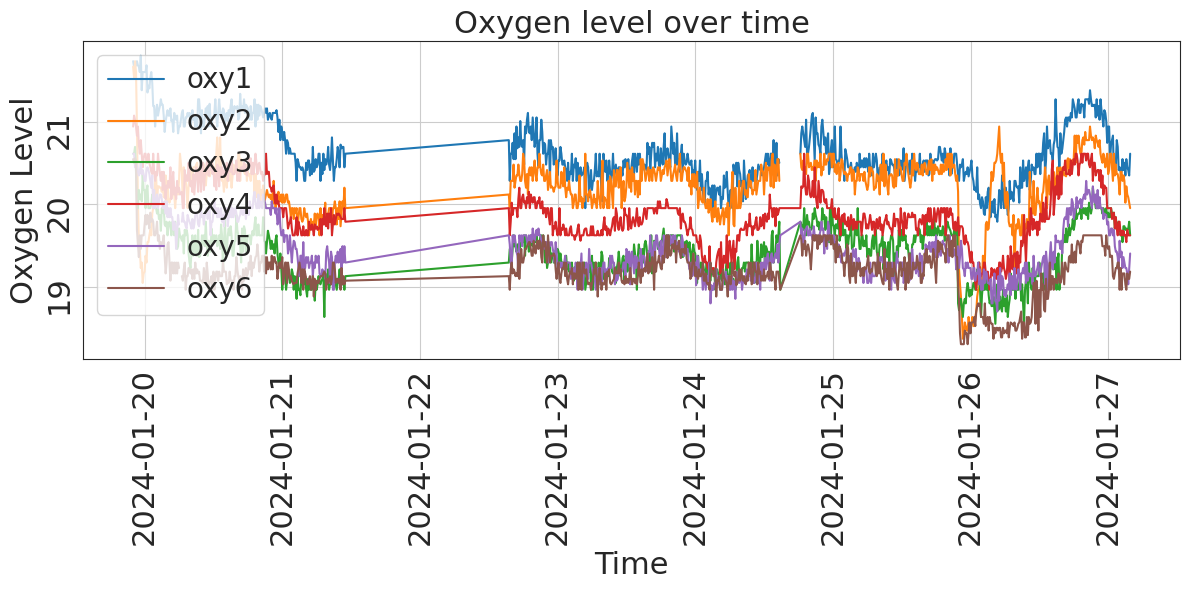

In [50]:
# plot 4 cols in df_lora_10min in one figure
# df_lora_10min = df_lora_10min.iloc[500:]
# Path: /home/yuning/Desktop/yuning/AgMAR/figures
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_lora_10min['time'], df_lora_10min['oxy1'], label='oxy1')
ax.plot(df_lora_10min['time'], df_lora_10min['oxy2'], label='oxy2')
ax.plot(df_lora_10min['time'], df_lora_10min['oxy3'], label='oxy3')
ax.plot(df_lora_10min['time'], df_lora_10min['oxy4'], label='oxy4')
ax.plot(df_lora_10min['time'], df_lora_10min['oxy5'], label='oxy5')
ax.plot(df_lora_10min['time'], df_lora_10min['oxy6'], label='oxy6')

ax.set_xlabel('Time', fontsize=label_size)
ax.set_ylabel('Oxygen Level', fontsize=label_size)

ax.set_title('Oxygen level over time', fontsize=label_size)
ax.legend(loc='upper left', fontsize=legend_size)
ax.tick_params(axis='both', which='major', labelsize=ticks_size, rotation=90)
ax.grid(True)
plt.tight_layout()
plt.savefig('/home/yuning/Desktop/yuning/AgMAR/figures/oxy.pdf', dpi=300)


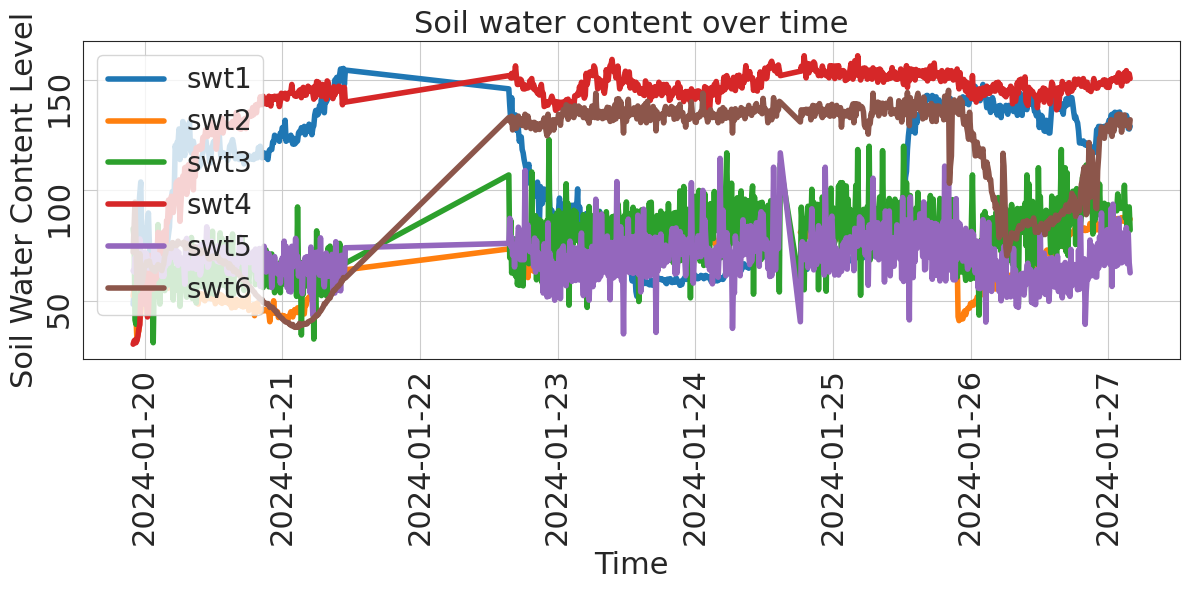

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_lora_10min['time'], df_lora_10min['swt1'], label='swt1', linewidth=linewidth_t)
ax.plot(df_lora_10min['time'], df_lora_10min['swt2'], label='swt2', linewidth=linewidth_t)
ax.plot(df_lora_10min['time'], df_lora_10min['swt3'], label='swt3', linewidth=linewidth_t)
ax.plot(df_lora_10min['time'], df_lora_10min['swt4'], label='swt4', linewidth=linewidth_t)
ax.plot(df_lora_10min['time'], df_lora_10min['swt5'], label='swt5', linewidth=linewidth_t)
ax.plot(df_lora_10min['time'], df_lora_10min['swt6'], label='swt6', linewidth=linewidth_t)

ax.set_xlabel('Time', fontsize=label_size)
ax.set_ylabel('Soil Water Content Level', fontsize=label_size)
ax.set_title('Soil water content over time', fontsize=label_size)
ax.legend(loc='upper left', fontsize=legend_size)
ax.tick_params(axis='both', which='major', labelsize=ticks_size, rotation=90)
ax.grid(True)
plt.tight_layout()
plt.savefig('/home/yuning/Desktop/yuning/AgMAR/figures/swt.pdf', dpi=300)

In [5]:
# Heuristic planning

# set up a 720-long array, each element can only be 0 or 1, 0 means no flooding, 1 means flooding.
# After a substring '01', then the following 120 char can only be '1'
# After a substring '10', then the following 120 char can only be '0'
# Please give the number of all possible solutions for the 720-long array

from functools import lru_cache

@lru_cache(None)
def count_sequences(last_two, remaining):
    # When no characters left to place, there's 1 way to end this sequence.
    if remaining == 0:
        return 1
    
    # Define the constraint based on the last two characters placed
    if last_two == "01":
        if remaining >= 144 and remaining <= 216:
            # Must place 120 '1's next
            return count_sequences("11", remaining - 120)
        else:
            # Not enough space left to place all 120 '1's required
            return 0
    elif last_two == "10":
        if remaining >= 288: 
            # Must place 120 '0's next
            return count_sequences("00", remaining - 120)
        else:
            # Not enough space left to place all 120 '0's required
            return 0
    else:
        # Current situation can either place a '0' or a '1' and continue
        total = 0
        if remaining > 1:
            total += count_sequences(last_two[-1] + "0", remaining - 1)
            total += count_sequences(last_two[-1] + "1", remaining - 1)
        else:
            # Only one character left, append either '0' or '1'
            total += count_sequences(last_two[-1] + "0", remaining - 1)
            total += count_sequences(last_two[-1] + "1", remaining - 1)
        
        return total

# Store the proposals into csv files
proposals = pd.DataFrame(columns=['sat'])

61488

In [ ]:
# Forecasting
! python3 /home/yuning/Desktop/yuning/AgMAR/long_term_forecasting.py

In [ ]:
# Optimization
# there is a csv file named "forecasting_res.csv" in the folder, 3 columns, "proposal" and "lowest_peak" and "recharging_amount"
# read it, find the proposal with the "lowest_peak" >= 10, and the highest "recharging_amount"

inference_result = pd.read_csv("/home/yuning/Desktop/yuning/AgMAR/forecasting_res.csv")
inference_result = inference_result[inference_result['lowest_peak'] >= 10]
inference_result = inference_result.sort_values(by='recharging_amount', ascending=False)
# get the proposal with the highest "recharging_amount" and print the proposal
proposal = inference_result.iloc[0]['proposal']
print('The best proposal is: ', proposal, 'Next step is: ', proposal[0])
